In [1]:
import errno
import os
from collections import defaultdict
import time
import shutil  
import psutil
import subprocess
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import glob
import ptmpsi
from matplotlib.colors import LinearSegmentedColormap
import ptmpsi.gromacs.analysis

no_ptm_matrix_path = '/anfhome/shared/qipd/newmds/postprocess/no_PTM/randomstring/0000/contact_test/final_matrix.xvg'
no_ptm_matrix = np.loadtxt(no_ptm_matrix_path, comments=['@', '#'])

# Function to save the matrix
def save_matrix(matrix, filename):
    np.savetxt(filename, matrix, fmt='%.6f')
    print(f"Matrix saved in {filename}")
    
def check_file_exists(filename, canbenone=False):
    #
    # Check if filename is None
    if filename is None: 
        if canbenone: 
            return
        else:
            raise KeyError("filename cannot be None")
    #
    # Check if file exists
    if not os.path.isfile(filename):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)
    return

def run_commands(i, j, begin, end, trajectory_path, structure_path, index_path, output_dir, commands_base):
    basename_index = os.path.basename(os.path.dirname(trajectory_path))
    contact_file = f"{basename_index}_dist_{begin}.xvg"
    output_file = os.path.join(output_dir, contact_file)
    command = commands_base.format(
        trajectory=trajectory_path,
        structure=structure_path,
        begin=begin,
        end=end,
        output_file=output_file
    )
    if index_path is not None:
        command += f" -n {index_path}"
    
    #print(f"Executing command: {command}")
    #print(f"Output file will be saved at: {output_file}")
    
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, cwd=output_dir)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(f"Error in processing {contact_file}. Command failed")
        print(f"stdout: {stdout.decode()}")
        print(f"stderr: {stderr.decode()}")
    return output_file
    
def construct_residue_path(file_path):
    """
    Remove 'postprocess' and the last two parts of the path, and append 'residuetypes.dat'.
    """
    # Split the path into parts
    path_parts = file_path.split('/')
    
    # Remove 'postprocess' if it exists
    if 'postprocess' in path_parts:
        path_parts.remove('postprocess')
    
    # Remove the last two parts (file name and the preceding directory)
    base_path = '/'.join(path_parts[:-2])
    
    # Append 'residuetypes.dat' to the remaining path
    residue_path = os.path.join(base_path, 'residuetypes.dat')
    
    return residue_path

def add_residue_file(file_path):
    """
    Add 'residuetypes.dat' to the working directory if it doesn't exist.
    """
    # Construct the path where 'residuetypes.dat' should be
    residue_path = construct_residue_path(file_path)
    print("residue path is:", residue_path)

    # Check if the file already exists
    working_dir = os.getcwd()
    parent_dir = os.path.dirname(working_dir) 
    destination_path = os.path.join(parent_dir, 'residuetypes.dat')
    if not os.path.exists(destination_path):
        # If not, copy it from the source path to working directory
        print(residue_path)
        shutil.copy(residue_path, working_dir)
        print("copied")
    else:
        print(f"'{residue_path}' already exists. Nothing to do.")

def contact_map(trajectory, structure, md_file, output_dir, index=None, interactive=False, maxprocs=120, start_residue=None, end_residue=None, **kwargs,):
    print("1) Initial working directory is:", os.getcwd())
    if not os.path.exists(output_dir):
        print(f"Directory {output_dir} does not exist. Creating it now.")
        try:
            os.makedirs(output_dir)
            print(f"Directory {output_dir} created successfully.")
        except OSError as e:
            print(f"Failed to create {output_dir}. Error: {e}")
            raise
    else:
        print(f"Directory {output_dir} already exists.")
    print(f"Changing to output directory: {output_dir}")
    original_directory = os.getcwd()
    os.chdir(output_dir)
    print("2) Current working directory is:", os.getcwd())
    add_residue_file(trajectory)
    __trajectories = trajectory if isinstance(trajectory, list) else [trajectory]
    __structures   = structure  if isinstance(structure, list) else [structure]
    __indices      = index      if isinstance(index, list) else [index]
    ntraj = len(__trajectories)
    for i in range(ntraj):
        check_file_exists(__trajectories[i])
        check_file_exists(__structures[i])
        if __indices[i] is not None:
            check_file_exists(__indices[i])
    if interactive:
        nprocs    = min(psutil.cpu_count(logical=False), maxprocs)
        nlogical  = psutil.cpu_count()
        nskip     = max(1, int(nlogical / nprocs))

        print(f"Found {nprocs} physical CPUs available")
        print(f"Will use {nprocs} CPUs at the same time")
        
        result_files = []

        commands_base = (
            "source /anfhome/.profile && module load gcc/13.2.0 intel-oneapi-mkl/2023.2.0/gcc13.2.0-hpcx_mpi-ddupx "
            "&& source /anfhome/shared/qipd/gromacs/bin/GMXRC && "
            "gmx pairdist -f {trajectory} -s {structure} -b {begin} -e {end} -refgrouping res -selgrouping res "
            "-ref 0 -sel 0 -o {output_file} -cutoff 1.0 -dt 500"
        )

        with ProcessPoolExecutor(max_workers=nprocs) as executor:
            futures = []
            for i in range(ntraj):
                num_frames = 0
                total_frames = 49420
                while num_frames < total_frames:
                    begin, end = num_frames, num_frames #+ 2000
                    futures.append(executor.submit(
                        run_commands, i, 0, begin, end, __trajectories[i],
                        __structures[i], __indices[i], output_dir, commands_base
                    ))
                    num_frames += 1000

            for future in as_completed(futures):
                result_file = future.result()
                if result_file:
                    result_files.append(result_file)

        process_contact(result_files, start_residue=None, end_residue=None)
         
    os.chdir(original_directory)
    print("3) Changed back to original directory:", os.getcwd())


def process_single_file(contact_file):
    try:
        with open(contact_file, 'r', encoding='latin-1') as file:
            lines = file.readlines()[24:]  # Skip any header lines
            if not lines:
                print(f"No data available in file: {contact_file}")
                return None
            
            first_line = lines[0]
            parts = first_line.split()
            nres = int(np.floor(np.sqrt(len(parts))))
            #nres=4237
            contact_matrix = np.zeros((nres, nres))
            frame_count = 0
            
            for line in lines:
                parts = [float(entry) for entry in line.split()]
                if len(parts) < nres * nres:
                    print(f"Skipping line due to insufficient data: {line}")
                    continue
              
                frame_count += 1
                index = 0
                for i in range(nres):
                    for j in range(nres):
                        if index < len(parts) and parts[index] > 0.7:
                            contact_matrix[i, j] += 1
                        index += 1
            
            # Normalize by the frame count to get the average
            if frame_count > 0:
                contact_matrix /= frame_count  # Normalize by number of frames
            
            return contact_matrix
    except Exception as e:
        print(f"Error processing file {contact_file}: {e}")
        return None

def generate_plot_title_and_filename(contact_file):
    PTM_TYPES = {
        "0000": "reduction",
        "0001": "nitrosylation",
        "0002": "sulfhydration",
        "0003": "glutathionylation",
        "0004": "nitrosylation",
        "0005": "sulfhydration",
        "0006": "glutathionylation",
        "0007": "nitrosylation",
        "0008": "sulfhydration",
        "0009": "glutathionylation",
        "0010": "nitrosylation",
        "0011": "sulfhydration",
        "0012": "glutathionylation",
        "0013": "reduction",
        "0014": "reduction",
        "0015": "reduction"
    }

    # Extract parts of the file path
    directory_parts = contact_file.split(os.sep)
    
    # Construct the output directory based on the input file structure
    try:
        NAD = directory_parts[-5]  # NAD type
        string = directory_parts[-4]  # string 
        PTM = directory_parts[-3]  # Extract '0000'
    except IndexError:
        print(f"Unexpected file structure for: {contact_file}")
        return "Close Contact Heatmap", "/path/to/default_location/contact_heatmap.png"
    
    # Match PTM with PTM_TYPE
    ptm_type = PTM_TYPES.get(PTM, "Unknown PTM")
    
    # Update the plot title with PTM information
    plot_title = f"Fraction of Close Contact for Case {NAD} {PTM} for PTM: {ptm_type}"
    output_filename = f"{PTM}_{NAD}_close_contact.png"
    
    # Build the final output path
    output_dir = os.path.join(
        "/anfhome/shared/qipd/newmds/postprocess",
        NAD, 
        string,
        PTM,
        "contact_test"
    )
    
    # Make sure the directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    return plot_title, os.path.join(output_dir, output_filename)
"""
def plot_specific_residues(contact_matrix, start_residue, end_residue, plot_title, output_filename):
    if start_residue < 0 or end_residue >= contact_matrix.shape[0]:
        print("Residue index out of range.")
        return

    # Slice the contact matrix
    subset_matrix = contact_matrix[start_residue:4237, start_residue:4237]

    # Plotting the sliced matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(subset_matrix, cmap='YlGn_r', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Fraction of Close Contact')
    plt.xlabel(f'Residue Index (Columns) {start_residue}-{end_residue}')
    plt.ylabel(f'Residue Index (Rows) {start_residue}-{end_residue}')
    plt.title(plot_title)
    plt.savefig(output_filename, format='png')
    print(f"Heatmap saved as {output_filename}")
    plt.show()
"""

# Example use within `process_contact`:
def process_contact(contact_files, start_residue=None, end_residue=None):
    matrices = []
    total_frames = 0  # Initialize the total_frames variable
    
    if not contact_files:
        print("No contact files provided.")
        return

    with ProcessPoolExecutor() as executor:
        future_to_file = {executor.submit(process_single_file, cf): cf for cf in contact_files}
        
        for future in as_completed(future_to_file):
            contact_matrix = future.result()
            if contact_matrix is not None:
                matrices.append(contact_matrix)
                total_frames += 1  # Increment the total_frames count
    
    if not matrices:
        print("No valid data matrices found.")
        return

    if total_frames > 0:
        cumulative_matrix = sum(matrices)
        average_contact_matrix = cumulative_matrix / total_frames
     
        # Generate file paths
        plot_title, output_filename = generate_plot_title_and_filename(contact_files[0])
        output_dir = os.path.dirname(output_filename)
        matrix_filename = os.path.join(output_dir, "final_matrix.xvg")
        
        # Save the average matrix
        save_matrix(average_contact_matrix, matrix_filename)

        # If specific range is provided, plot that, otherwise default to full matrix
        if start_residue is not None and end_residue is not None:
            plot_specific_residues(average_contact_matrix, start_residue, end_residue, plot_title, output_filename)
        else:
            # Plot full matrix if range not specified
            plot_specific_residues(average_contact_matrix, 0, average_contact_matrix.shape[0]-1, plot_title, output_filename)

    else:
        print("No frames were found to compute the average contact matrix.")
# Example usage:
# process_contact(["/path/to/your/contact_file1.txt"])

def plot_specific_residues(contact_matrix, start_residue, end_residue, plot_title, output_filename):
    rows, columns = no_ptm_matrix.shape
    # Adjust start_residue and end_residue to fit within 0 to 4237
    start_residue = max(0, start_residue)
    end_residue = min(rows, end_residue)

    if start_residue < 0 or end_residue >= contact_matrix.shape[0]:
        print("Residue index out of range.")
        return

    # Slice the contact matrix
    subset_matrix = contact_matrix[start_residue:end_residue, start_residue:end_residue]

    #subtract PTM case with no PTM case
    difference_matrix = subset_matrix - no_ptm_matrix

    # Define the custom colormap
    colors = [(1, 0.5, 0), (248/255, 255/255, 196/255), (0, 102, 102) ]  # Dark Red, Pale Yellow, Bright Green
    cmap_name = 'turn_a_good_color_map_on'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


    # Plotting the sliced matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(difference_matrix, cmap=cm, interpolation='nearest', aspect='auto')
    plt.colorbar(label='Difference in Contact Fraction Between with PTM and original')
    plt.xlabel(f'Residue Index (Columns) {start_residue}-{end_residue}')
    plt.ylabel(f'Residue Index (Rows) {start_residue}-{end_residue}')
    plt.title(plot_title)
    plt.savefig(output_filename, format='png')
    print(f"Heatmap saved as {output_filename}")
    plt.show()

Heatmap saved as plot


<Figure size 1000x800 with 0 Axes>

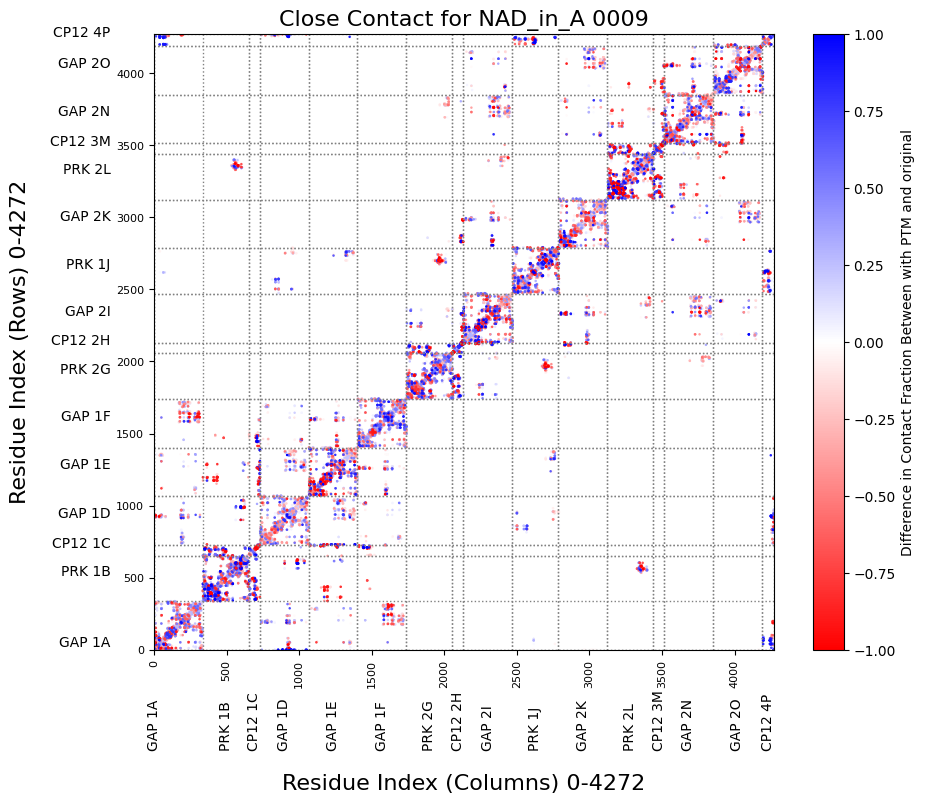

In [19]:
def plot_specific_residues(contact_matrix, start_residue, end_residue, plot_title, output_filename):
    rows, columns = no_ptm_matrix.shape
    # Adjust start_residue and end_residue to fit within 0 to 4237
    start_residue = max(0, start_residue)
    end_residue = min(rows, end_residue)

    if start_residue < 0 or end_residue >= contact_matrix.shape[0]:
        print("Residue index out of range.")
        return

    # Slice the contact matrix
    subset_matrix = contact_matrix[start_residue:end_residue, start_residue:end_residue]

    #subtract PTM case with no PTM case
    difference_matrix = subset_matrix - no_ptm_matrix
    M = difference_matrix
    row = []
    colmn = []
    color = []
    for i in range(len(M)):
        for j in range(len(M)):
            value = M[i,j]
            if abs(value) > 0:
                row.append(i)
                colmn.append(j)
                color.append(M[i,j])

    # Sort the data by the absolute value of the contact difference
    sorted_indices = np.argsort(np.abs(color))
    row = np.array(row)[sorted_indices]
    colmn = np.array(colmn)[sorted_indices]
    color = np.array(color)[sorted_indices]

    # Define the custom colormap
    colors = [(1, 0.5, 0), (248/255, 255/255, 196/255), (0, 102, 102) ]  # Dark Red, Pale Yellow, Bright Green
    cmap_name = 'turn_a_good_color_map_on'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

    # Example start and end indices
    start_indices = [0, 336, 653, 728, 1065, 1402, 1739, 2056, 2131, 2468, 2785, 3122, 3439, 3514, 3851, 4188]
    end_indices = [0, 653, 728, 1065, 1402, 1739, 2056, 2131, 2468, 2785, 3122, 3439, 3514, 3851, 4188, 4272]

    protein_and_chain = [
        "GAP 1A", "PRK 1B", "CP12 1C", "GAP 1D", "GAP 1E", "GAP 1F",
        "PRK 2G", "CP12 2H", "GAP 2I", "PRK 1J", "GAP 2K", "PRK 2L",
        "CP12 3M", "GAP 2N", "GAP 2O", "CP12 4P"
    ]


    colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red, White, Blue
    cmap_name = 'custom_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


    # Plotting the sliced matrix
    plt.figure(figsize=(10, 8))
    #plt.imshow(difference_matrix, cmap=cm, interpolation='nearest', aspect='auto')
    # Scatter plot of the contacts
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(row, colmn, c=color, cmap=cm, s=0.6, marker='o') 
    plt.colorbar(label='Difference in Contact Fraction Between with PTM and original')
    plt.xlabel(f'Residue Index (Columns) {start_residue}-{end_residue}')
    plt.ylabel(f'Residue Index (Rows) {start_residue}-{end_residue}')
    plt.title(plot_title, size=16)
    plt.xticks(np.arange(0, len(M), 500))
    plt.yticks(np.arange(0, len(M), 500))
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.xaxis.set_label_coords(0.5, -0.2)  # Move x-label downwards
    ax.yaxis.set_label_coords(-0.2, 0.5)  # Move y-label to the left
    ax.xaxis.label.set_size(16)  # Change size if necessary
    ax.yaxis.label.set_size(16)  # Change size if necessary

    
    # Add boundary lines and labels
    for i, (start, end, label) in enumerate(zip(start_indices, end_indices, protein_and_chain)):
        plt.axvline(x=start, color='grey', linestyle=':', linewidth=1)
        plt.axvline(x=end, color='grey', linestyle=':', linewidth=1)
        plt.axhline(y=start, color='grey', linestyle=':', linewidth=1)
        plt.axhline(y=end, color='grey', linestyle=':', linewidth=1)

        # Adjust the label positions
        plt.text((start + end) / 2, -700, label, rotation=90, horizontalalignment='center', verticalalignment='bottom', fontsize=10, ha='center')
        plt.text(-300, (start + end) / 2, label, rotation=0, horizontalalignment='center', verticalalignment='bottom', fontsize=10, ha='right')
        
    # Rotate x-axis labels
    plt.xticks(rotation=90)
    plt.xlim(0, 4272)
    plt.ylim(0, 4272)
    #plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=1)
    plt.savefig(output_filename, format='png')
    print(f"Heatmap saved as {output_filename}")
    plt.show()

#use if files were already generated 

# Define the directory containing the .xvg files
directory_path = '/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test/final_matrix.xvg'
matrix = np.loadtxt(directory_path, comments=['@', '#'])

# Run the process_contact function with the gathered .xvg files
plot_specific_residues(matrix, 0, 4272, "Close Contact for NAD_in_A 0009", 'plot')

###### use if files were already generated 

# Define the directory containing the .xvg files
directory_path = '/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test/final_matrix.xvg'
matrix = np.loadtxt(directory_path, comments=['@', '#'])

# Run the process_contact function with the gathered .xvg files
plot_specific_residues(matrix, 0, 5000, "Close Contact for NAD_in_A 0009", 'plot')

In [ ]:
DONE /anfhome/shared/qipd/newmds/postprocess/NAD_in_AD/eda6b09c-b9f2-42c9-be15-0204ed29807a 0000 0001 0002
/anfhome/shared/qipd/newmds/postprocess/no_PTM/randomstring

OTHERS: 
/anfhome/shared/qipd/newmds/postprocess/no_PTM
/anfhome/shared/qipd/newmds/NAD_in_ADEFIKNO/1280ec92-875e-450d-966b-4550ebedc82e 
/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584 done
/anfhome/shared/qipd/newmds/postprocess/NAD_in_DE/6800f629-7cb9-4526-9f85-0c19eab37653 running


1) Initial working directory is: /anfhome/margot.lockwood/ptmpsi_env
Directory /anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test1 already exists.
Changing to output directory: /anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test1
2) Current working directory is: /anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test1
residue path is: /anfhome/shared/qipd/newmds/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/residuetypes.dat
/anfhome/shared/qipd/newmds/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/residuetypes.dat
copied
Found 120 physical CPUs available
Will use 120 CPUs at the same time
Matrix saved in /anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact_test/final_matrix.xvg
Heatmap saved as /anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584/0009/contact

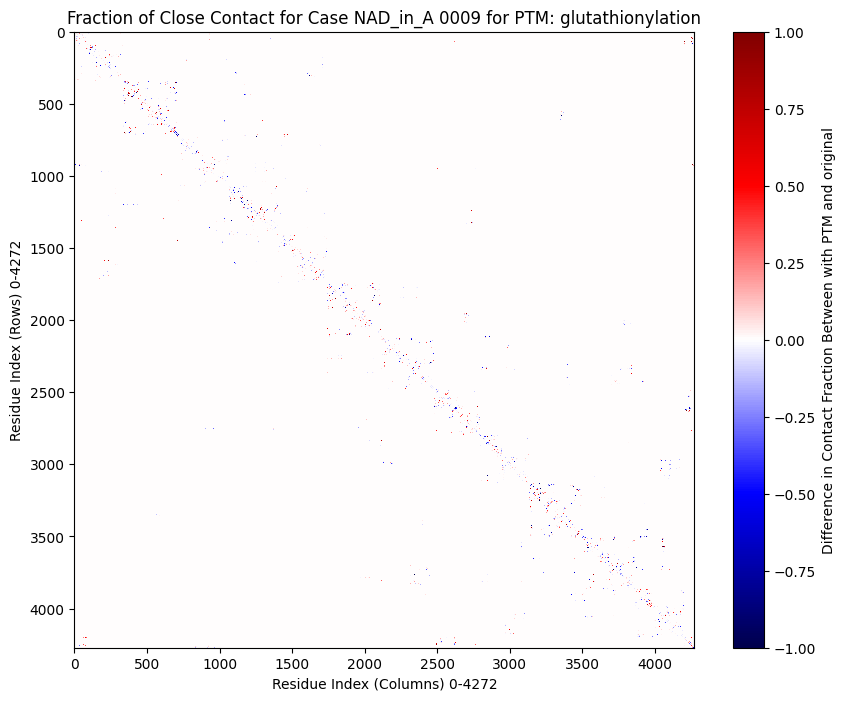

3) Changed back to original directory: /anfhome/margot.lockwood/ptmpsi_env
done


In [33]:
os.chdir("/anfhome/margot.lockwood/ptmpsi_env")

file=["/anfhome/shared/qipd/newmds/postprocess/NAD_in_A/563e2df5-82de-4918-967d-70e733cfa584"] #note this file path is the location of the post_process prefix 

# NEED TO DO 0 to 14 
for filename in file:
    for n in [9]:
        if n<10:
            trajectory = f"{filename}/000{n}/md_whole_nojump_fit.xtc"
            structure  = f"{filename}/000{n}/md_Non-Water.tpr"
            md  = f"{filename}/000{n}/md.gro"
            contact_map(trajectory, structure, md, output_dir=f"{filename}/000{n}/contact_test1", interactive=True, start_residue=None, end_residue=4264)
            #ptmpsi.gromacs.analysis.rmsd(trajectory, structure, output_dir=f"{filename}/000{n}/rmsd", interactive=True)
        else: 
            trajectory = f"{filename}/00{n}/md_whole_nojump_fit.xtc"
            structure  = f"{filename}/00{n}/md_Non-Water.tpr"
            md  = f"{filename}/00{n}/md.gro"
        
            contact_map(trajectory, structure, md, output_dir=f"{filename}/00{n}/contact_test", interactive=True, start_residue=0, end_residue=4264)
            #ptmpsi.gromacs.analysis.rmsd(trajectory, structure, output_dir=f"{filename}/00{n}/rmsdd", interactive=True)
print("done")

In [ ]:
import errno
import os
from collections import defaultdict
import time
import shutil  
import psutil
import subprocess
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import glob
import ptmpsi
import ptmpsi.gromacs.analysis

def compute_contact_matrix(contact_files):
    matrices = []
    total_frames = 0

    if not contact_files:
        print("No contact files provided.")
        return None

    with ProcessPoolExecutor() as executor:
        future_to_file = {executor.submit(process_single_file, cf): cf for cf in contact_files}
        
        for future in as_completed(future_to_file):
            contact_matrix = future.result()
            if contact_matrix is not None:
                matrices.append(contact_matrix)
                total_frames += 1

    if not matrices:
        print("No valid data matrices found.")
        return None
    
    if total_frames > 0:
        cumulative_matrix = sum(matrices)
        average_contact_matrix = cumulative_matrix / total_frames
        return average_contact_matrix
    
    print("No frames were found to compute the average contact matrix.")
    return None

def subtract_and_plot(no_ptm_matrix, case_matrix, plot_title, output_filename):
    # Ensure both matrices are the same shape
    if no_ptm_matrix.shape != case_matrix.shape:
        print("Matrix sizes don't match!")
        return
    
    difference_matrix = case_matrix - no_ptm_matrix

    # Plot the difference matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(difference_matrix, cmap='bwr', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Difference in Contact Fraction')
    plt.xlabel('Residue Index (Columns)')
    plt.ylabel('Residue Index (Rows)')
    plt.title(plot_title)
    plt.savefig(output_filename, format='png')
    plt.show()
    print(f"Difference heatmap saved as {output_filename}")
                
# Function to save the matrix
def save_matrix(matrix, filename):
    np.savetxt(filename, matrix, fmt='%.6f')
    print(f"Matrix saved in {filename}")
    
def check_file_exists(filename, canbenone=False):
    #
    # Check if filename is None
    if filename is None: 
        if canbenone: 
            return
        else:
            raise KeyError("filename cannot be None")
    #
    # Check if file exists
    if not os.path.isfile(filename):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)
    return

def run_commands(i, j, begin, end, trajectory_path, structure_path, index_path, output_dir, commands_base):
    basename_index = os.path.basename(os.path.dirname(trajectory_path))
    contact_file = f"{basename_index}_dist_{begin}.xvg"
    output_file = os.path.join(output_dir, contact_file)
    command = commands_base.format(
        trajectory=trajectory_path,
        structure=structure_path,
        begin=begin,
        end=end,
        output_file=output_file
    )
    if index_path is not None:
        command += f" -n {index_path}"
    
    #print(f"Executing command: {command}")
    #print(f"Output file will be saved at: {output_file}")
    
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, cwd=output_dir)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(f"Error in processing {contact_file}. Command failed")
        print(f"stdout: {stdout.decode()}")
        print(f"stderr: {stderr.decode()}")
    return output_file
    
def construct_residue_path(file_path):
    """
    Remove 'postprocess' and the last two parts of the path, and append 'residuetypes.dat'.
    """
    # Split the path into parts
    path_parts = file_path.split('/')
    
    # Remove 'postprocess' if it exists
    if 'postprocess' in path_parts:
        path_parts.remove('postprocess')
    
    # Remove the last two parts (file name and the preceding directory)
    base_path = '/'.join(path_parts[:-2])
    
    # Append 'residuetypes.dat' to the remaining path
    residue_path = os.path.join(base_path, 'residuetypes.dat')
    
    return residue_path

def add_residue_file(file_path):
    """
    Add 'residuetypes.dat' to the working directory if it doesn't exist.
    """
    # Construct the path where 'residuetypes.dat' should be
    residue_path = construct_residue_path(file_path)
    print("residue path is:", residue_path)

    # Check if the file already exists
    working_dir = os.getcwd()
    parent_dir = os.path.dirname(working_dir) 
    destination_path = os.path.join(parent_dir, 'residuetypes.dat')
    if not os.path.exists(destination_path):
        # If not, copy it from the source path to working directory
        print(residue_path)
        shutil.copy(residue_path, working_dir)
        print("copied")
    else:
        print(f"'{residue_path}' already exists. Nothing to do.")

def contact_map(trajectory, structure, md_file, output_dir, index=None, interactive=False, maxprocs=120, start_residue=None, end_residue=None, **kwargs,):
    print("1) Initial working directory is:", os.getcwd())
    if not os.path.exists(output_dir):
        print(f"Directory {output_dir} does not exist. Creating it now.")
        try:
            os.makedirs(output_dir)
            print(f"Directory {output_dir} created successfully.")
        except OSError as e:
            print(f"Failed to create {output_dir}. Error: {e}")
            raise
    else:
        print(f"Directory {output_dir} already exists.")
    print(f"Changing to output directory: {output_dir}")
    original_directory = os.getcwd()
    os.chdir(output_dir)
    print("2) Current working directory is:", os.getcwd())
    add_residue_file(trajectory)
    __trajectories = trajectory if isinstance(trajectory, list) else [trajectory]
    __structures   = structure  if isinstance(structure, list) else [structure]
    __indices      = index      if isinstance(index, list) else [index]
    ntraj = len(__trajectories)
    for i in range(ntraj):
        check_file_exists(__trajectories[i])
        check_file_exists(__structures[i])
        if __indices[i] is not None:
            check_file_exists(__indices[i])
    if interactive:
        nprocs    = min(psutil.cpu_count(logical=False), maxprocs)
        nlogical  = psutil.cpu_count()
        nskip     = max(1, int(nlogical / nprocs))

        print(f"Found {nprocs} physical CPUs available")
        print(f"Will use {nprocs} CPUs at the same time")
        
        result_files = []

        commands_base = (
            "source /anfhome/.profile && module load gcc/13.2.0 intel-oneapi-mkl/2023.2.0/gcc13.2.0-hpcx_mpi-ddupx "
            "&& source /anfhome/shared/qipd/gromacs/bin/GMXRC && "
            "gmx pairdist -f {trajectory} -s {structure} -b {begin} -e {end} -refgrouping res -selgrouping res "
            "-ref 0 -sel 0 -o {output_file} -cutoff 1.0 -dt 500"
        )

        with ProcessPoolExecutor(max_workers=nprocs) as executor:
            futures = []
            for i in range(ntraj):
                num_frames = 0
                total_frames = 49420
                while num_frames < total_frames:
                    begin, end = num_frames, num_frames #+ 2000
                    futures.append(executor.submit(
                        run_commands, i, 0, begin, end, __trajectories[i],
                        __structures[i], __indices[i], output_dir, commands_base
                    ))
                    num_frames += 1000

            for future in as_completed(futures):
                result_file = future.result()
                if result_file:
                    result_files.append(result_file)

        process_contact(result_files, start_residue=None, end_residue=None)
         
    os.chdir(original_directory)
    print("3) Changed back to original directory:", os.getcwd())


def process_single_file(contact_file):
    try:
        with open(contact_file, 'r', encoding='latin-1') as file:
            lines = file.readlines()[24:]  # Skip any header lines
            if not lines:
                print(f"No data available in file: {contact_file}")
                return None
            
            first_line = lines[0]
            parts = first_line.split()
            nres = int(np.floor(np.sqrt(len(parts))))
            #nres=4237
            contact_matrix = np.zeros((nres, nres))
            frame_count = 0
            
            for line in lines:
                parts = [float(entry) for entry in line.split()]
                if len(parts) < nres * nres:
                    print(f"Skipping line due to insufficient data: {line}")
                    continue
              
                frame_count += 1
                index = 0
                for i in range(nres):
                    for j in range(nres):
                        if index < len(parts) and parts[index] > 0.7:
                            contact_matrix[i, j] += 1
                        index += 1
            
            # Normalize by the frame count to get the average
            if frame_count > 0:
                contact_matrix /= frame_count  # Normalize by number of frames
            
            return contact_matrix
    except Exception as e:
        print(f"Error processing file {contact_file}: {e}")
        return None

def generate_plot_title_and_filename(contact_file):
    PTM_TYPES = {
        "0000": "reduction",
        "0001": "nitrosylation",
        "0002": "sulfhydration",
        "0003": "glutathionylation",
        "0004": "nitrosylation",
        "0005": "sulfhydration",
        "0006": "glutathionylation",
        "0007": "nitrosylation",
        "0008": "sulfhydration",
        "0009": "glutathionylation",
        "0010": "nitrosylation",
        "0011": "sulfhydration",
        "0012": "glutathionylation",
        "0013": "reduction",
        "0014": "reduction",
        "0015": "reduction"
    }

    # Extract parts of the file path
    directory_parts = contact_file.split(os.sep)
    
    # Construct the output directory based on the input file structure
    try:
        NAD = directory_parts[-5]  # NAD type
        string = directory_parts[-4]  # string 
        PTM = directory_parts[-3]  # Extract '0000'
    except IndexError:
        print(f"Unexpected file structure for: {contact_file}")
        return "Close Contact Heatmap", "/path/to/default_location/contact_heatmap.png"
    
    # Match PTM with PTM_TYPE
    ptm_type = PTM_TYPES.get(PTM, "Unknown PTM")
    
    # Update the plot title with PTM information
    plot_title = f"Fraction of Close Contact for Case {NAD} {PTM} for PTM: {ptm_type}"
    output_filename = f"{PTM}_{NAD}_close_contact.png"
    
    # Build the final output path
    output_dir = os.path.join(
        "/anfhome/shared/qipd/newmds/postprocess",
        NAD, 
        string,
        PTM,
        "contact_test"
    )
    
    # Make sure the directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    return plot_title, os.path.join(output_dir, output_filename)
"""
def plot_specific_residues(contact_matrix, start_residue, end_residue, plot_title, output_filename):
    if start_residue < 0 or end_residue >= contact_matrix.shape[0]:
        print("Residue index out of range.")
        return

    # Slice the contact matrix
    subset_matrix = contact_matrix[start_residue:4237, start_residue:4237]

    # Plotting the sliced matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(subset_matrix, cmap='YlGn_r', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Fraction of Close Contact')
    plt.xlabel(f'Residue Index (Columns) {start_residue}-{end_residue}')
    plt.ylabel(f'Residue Index (Rows) {start_residue}-{end_residue}')
    plt.title(plot_title)
    plt.savefig(output_filename, format='png')
    print(f"Heatmap saved as {output_filename}")
    plt.show()
"""

# Example use within `process_contact`:
def process_contact(contact_files, start_residue=None, end_residue=None):
    matrices = []
    total_frames = 0  # Initialize the total_frames variable
    
    if not contact_files:
        print("No contact files provided.")
        return

    with ProcessPoolExecutor() as executor:
        future_to_file = {executor.submit(process_single_file, cf): cf for cf in contact_files}
        
        for future in as_completed(future_to_file):
            contact_matrix = future.result()
            if contact_matrix is not None:
                matrices.append(contact_matrix)
                total_frames += 1  # Increment the total_frames count
    
    if not matrices:
        print("No valid data matrices found.")
        return

    if total_frames > 0:
        cumulative_matrix = sum(matrices)
        average_contact_matrix = cumulative_matrix / total_frames
     
        # Generate file paths
        plot_title, output_filename = generate_plot_title_and_filename(contact_files[0])
        output_dir = os.path.dirname(output_filename)
        matrix_filename = os.path.join(output_dir, "final_matrix.xvg")
        
        # Save the average matrix
        save_matrix(average_contact_matrix, matrix_filename)

        # If specific range is provided, plot that, otherwise default to full matrix
        if start_residue is not None and end_residue is not None:
            plot_specific_residues(average_contact_matrix, start_residue, end_residue, plot_title, output_filename)
        else:
            # Plot full matrix if range not specified
            plot_specific_residues(average_contact_matrix, 0, average_contact_matrix.shape[0]-1, plot_title, output_filename)

    else:
        print("No frames were found to compute the average contact matrix.")
# Example usage:
# process_contact(["/path/to/your/contact_file1.txt"])

def plot_specific_residues(contact_matrix, start_residue, end_residue, plot_title, output_filename):
    # Adjust start_residue and end_residue to fit within 0 to 4237
    start_residue = max(0, start_residue)
    end_residue = min(4264, end_residue)

    if start_residue < 0 or end_residue >= contact_matrix.shape[0]:
        print("Residue index out of range.")
        return

    # Slice the contact matrix
    subset_matrix = contact_matrix[start_residue:end_residue+1, start_residue:end_residue+1]

    # Plotting the sliced matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(subset_matrix, cmap='YlGn_r', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Fraction of Close Contact')
    plt.xlabel(f'Residue Index (Columns) {start_residue}-{end_residue}')
    plt.ylabel(f'Residue Index (Rows) {start_residue}-{end_residue}')
    plt.title(plot_title)
    plt.savefig(output_filename, format='png')
    print(f"Heatmap saved as {output_filename}")
    plt.show()